==============================================================================================
# Practicum 5 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Group A- Group F): November 23th, 23:00 h**

**Deadline (Group B): November 24th, 23:00 h**

==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

**Part 1:**

- Gaussian filters
- Descriptors based on texture 

**Part 2:**

- Distance between images and similarity search


### Imports

In [2]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize


import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Wrapper function to easily use subplot    
import math
def print_images(images, titles=None, ncols=None, colormap=None):
    if ncols == None: #If no number of columns is given, we will print everything in one row
        ncols = len(images)
    if titles == None or len(titles) != len(images): #Empty titles if no titles given or dimension mismatch 
        titles = ["" for i in range(len(images))]
    
    nrows = math.ceil(len(images)/ncols) #Compute the number of rows required to print everythong in ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(15,5)) #Generate subplot
    
    #Switch off every axis
    for x in ax.ravel():
        x.axis("off")
        
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols + j >= len(images): #Stop if every image has been printed, even if the grid is not "complete"
                break;
            ax[i,j].imshow(images[i*ncols + j], cmap=colormap) #Set subplot with given colormap
            ax[i,j].set_title(titles[i*ncols + j])
    plt.show() #Show subplots
    return

# RGB convolution
def convolute_rgb(im, mask):
    im_conv = img_as_ubyte(rgba2rgb(im)) #Convert the image to rgb and to uint (we could also convolute as float)
    for i in range(3): #For each channel
        im_conv[..., i] = convolve(im_conv[...,i], mask) #Do a 2D convolution with selected mask
    return im_conv

#Function to easily print image details
def print_im_detail(image):
    print('Type: ', image.dtype, ' Min.value: ', image.min(), ' Max.value: ', image.max(), ' Image shape: ', image.shape)
    
#Normalization function
def normalize(image):
    return (image.copy()-image.min())/(image.max()-image.min())

# 1 Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


We import Leung-Malik filters as follows:

In [3]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


**1.1** Check what the makeLMfilters reurn and plot all the filters using ``plt.subplots()``

**Hint:** In order to perform a correct visualization, please, check how many filters are in the filter bank.

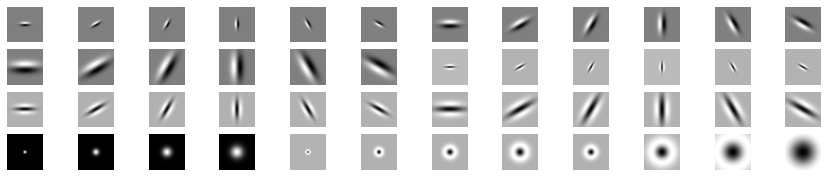

In [4]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


Which is the size of the filters? How many filters there are?

In [5]:
# Your solution here
print(filter_bank[..., 0].shape)

(49, 49)


### Answer 
The shape of each filter is $49\times 49$ pixels and there are $48$ filters

## Visualize Features

**1.2** Read the image ``/images/pizza.jpg``, and resize it to 250𝑥250 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

Type:  uint8  Min.value:  0  Max.value:  255  Image shape:  (512, 512, 3)


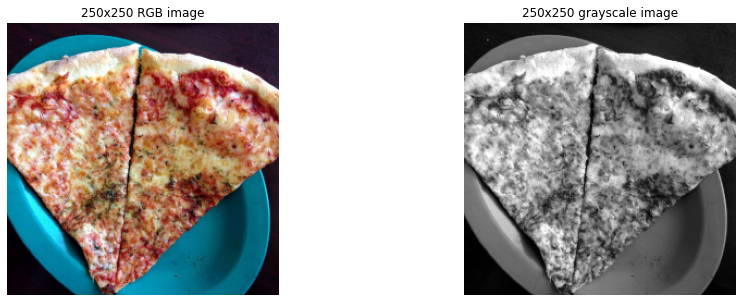

In [7]:
#Read image
pizza = io.imread("./images/pizza.jpg")
print_im_detail(pizza)

#Resize to 250 x 250 and convert it to grayscale
pizza_250 = resize(pizza, (250,250, 3))
pizza_250_g = rgb2gray(pizza_250)

#Print both images
print_images([pizza_250, pizza_250_g], ["250x250 RGB image", "250x250 grayscale image"], colormap='gray')

**1.3** Make a function `visualize_filters(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [8]:
from scipy.ndimage import convolve

#Function to visualize filters: aplies first n_filters filters to im and shows 
# the resulting images and the filter used in each image
def visualize_filters(im,  filter_bank, n_filters=5):
    #Build an array with the absolute value of the convolution of the image for each filter
    masked = [np.abs(convolve(im, fil)) for fil in filter_bank[:n_filters]]
    #Print them whith the correspondig filter under 
    print_images(masked + list(filter_bank[:n_filters]), ncols=n_filters, colormap='gray')


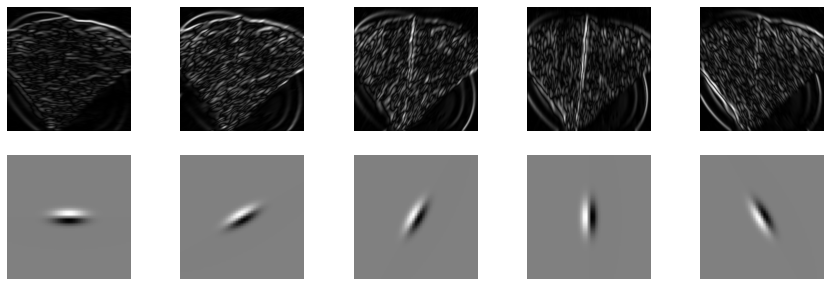

In [9]:
## Try the function
'''
We find more natural to have the frames dimension at the first 
    index so accessing to the filters is done by filters[i] insetead of filters[..., i].
    We have changed the dimensions accordingly and assumed this change at every function
'''

filter_bank = LM_filters.makeLMfilters()
filter_bank = np.moveaxis(filter_bank, -1, 0) 

pizza = pizza_250_g
visualize_filters(pizza, filter_bank)


**1.4** (Optional) Try ``visualize_filters()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

In [ ]:
# Your solution here


### Extracting a feature vector for an image

**1.5** Given $D$ filters from the filter bank and a single image `image`, make a function `extract_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image.  




In [15]:
def extract_features(image, filter_bank, n_filters=None):
    if n_filters == None:
        n_filters = len(filter_bank) #If no number of filters is given, use all of them
    
    masked = np.asarray([np.abs(convolve(image, fil)) for fil in filter_bank[:n_filters]]) #Compute the absoute value of the convolutions
    features = np.asarray([np.mean(img) for img in masked]) #Then compute the mean for each convolution
    return features

In [16]:
## Try the function with just 3 filters
n_filters = 3
features = extract_features(pizza, filter_bank, n_filters)
print(features)

[0.01580302 0.01435307 0.01414896]



**2.2** (Optional) Try ``extract_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [17]:
# Your solution here

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resized them to 250x250 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

**Hint:** You need to use ``os.listdir()`` to list all the images for each directory.

In [26]:
# Your solution here

#We use the ImageCollection to load all the images in the given directiories
pizza_images = io.ImageCollection("./images/pizza/*")
flowers_images = io.ImageCollection("./images/flowers/*")
pets_images = io.ImageCollection("./images/pets/*")

#ImageCollection returns a ImageCollection object, we pass them to array, resizing and converting each image to grayscale
pizza_images = [rgb2gray(resize(elem, (250,250, 3))) for elem in pizza_images]
flowers_images = [rgb2gray(resize(elem, (250,250, 3)))  for elem in flowers_images]
pets_images = [rgb2gray(resize(elem, (250,250, 3)))  for elem in pets_images]


#we culd have used os.listdir() as the hint proposes in the following manner:
#pizza_images = [imread("images/pizza/" + im) for im in os.listdir("images/pizza/")]

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

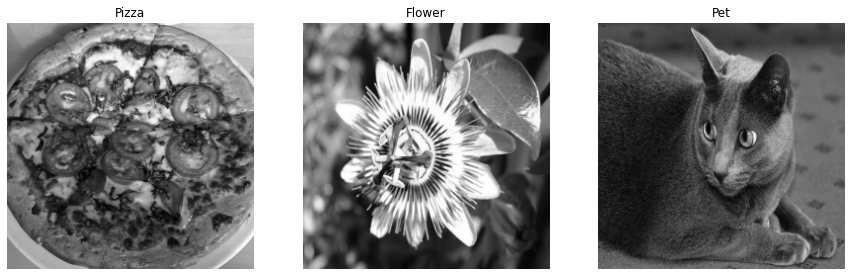

In [27]:
# Your solution here
print_images([pizza_images[0], flowers_images[0], pets_images[0]], ["Pizza", "Flower", "Pet"], colormap='gray')

How many images there are in each directory?

In [28]:
# Your solution here
print("Number of pizza images:", len(pizza_images))
print("Number of flower images:", len(flowers_images))
print("Number of pet images:", len(pets_images))

Number of pizza images: 30
Number of flower images: 28
Number of pet images: 29


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank)` that applies `extract_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [29]:
%%time
def get_dataset_features(all_images,  filter_bank):
    n_filters = filter_bank.shape[0] #Get the number of filters (we use index 0 because the change of the axis detailed above)
    feature_vectors = np.asarray([extract_features(image, filter_bank, n_filters) for image in all_images]) #Extract feature with all filters for each image
    
    return feature_vectors

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 22.6 µs


In [30]:
%%time

#Concatenate all images
all_images = pizza_images + flowers_images + pets_images


'''
As it takes some time to compute the feature vectors for each image and each filter we have included a 
     serialized object containing all the precomputed feature vectors. The following code tries to load
     this serialized object from a file called 'feature_vectors.pkl' before computing it. If the file is
     not found, then the feature vectors are coputed and serialized in said file. 
     
     Thus, if you wish to compute the feature vectors again, changing the expected filename for a non
     existent file will force to recompute.
'''

import pickle
filename = 'feature_vectors.pkl'
try:
    #If the file exists, load its contents to feature_vectors
    with open(filename, 'rb') as fp:
        feature_vectors = pickle.load(fp)
except:
    #Otherwise, compute feature_vectors
    feature_vectors = get_dataset_features(all_images, filter_bank)
    
    #and then serialixe them
    with open(filename, 'wb') as fp:
        pickle.dump(feature_vectors, fp, pickle.HIGHEST_PROTOCOL)
        
        

CPU times: user 374 µs, sys: 12 µs, total: 386 µs
Wall time: 257 µs


**2.3** Print the shape of `feature_vectors` as well as the features for image #0 (*i.e. all_images[0]*), image #30, and image #59, directly from the vector

In [31]:
print(feature_vectors.shape) #We have 87 images and 48 filters


(87, 48)


In [32]:
#print_images([feature_vectors[0], feature_vectors[30], feature_vectors[59]], ["image 0", "image 30", "image 59"], colormap='gray')

print(feature_vectors[0])
print(feature_vectors[30])
print(feature_vectors[59])

[1.72558991e-02 1.64405826e-02 1.47947771e-02 1.36167461e-02
 1.41317260e-02 1.56693482e-02 9.99954728e-03 9.08532685e-03
 8.04501303e-03 7.37077731e-03 7.74814926e-03 8.74499247e-03
 6.76226404e-03 6.08378843e-03 5.11410935e-03 4.84727425e-03
 5.38600349e-03 5.98291181e-03 8.03727392e-03 7.59679589e-03
 6.99035925e-03 6.30493242e-03 6.74072480e-03 7.43274621e-03
 2.70821493e-03 2.38752031e-03 2.21787896e-03 1.92192867e-03
 2.08134583e-03 2.31049376e-03 1.31501997e-03 1.14185964e-03
 1.02552750e-03 8.95460630e-04 9.95367256e-04 1.11154531e-03
 1.52807819e+00 3.05615639e+00 4.58423451e+00 6.11213592e+00
 7.64039096e-01 3.82019548e-01 2.54679570e-01 1.90894979e-01
 2.54679570e-01 1.17339882e-01 3.72713974e-02 2.82647993e-03]
[1.54756520e-02 1.58441523e-02 1.81523977e-02 1.98340443e-02
 1.88133947e-02 1.68146553e-02 1.02816167e-02 1.02377449e-02
 1.19416332e-02 1.31870734e-02 1.19260264e-02 1.06705434e-02
 7.65175005e-03 7.37325292e-03 8.60814253e-03 9.52327961e-03
 8.51140055e-03 7.71599

### Visualizing the features of an image

**2.4** Define a function `visualize_features` that given three different images, plots their features. Use different colors (red, green, and blue) to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

In [51]:
from skimage.exposure import histogram

def visualize_features(im_index, feature_vector):
    if len(im_index) != 3:
        print("it only works for 3 images")
        return
    n_bins = len(feature_vector[0])
    
    #hst_r, bins_r = histogram(feature_vector[im_index[0]], nbins=n_bins)
    #hst_g, bins_g = histogram(feature_vector[im_index[1]], nbins=n_bins)
    #hst_b, bins_b = histogram(feature_vector[im_index[2]], nbins=n_bins)
    
    hst_r = feature_vector[im_index[0]]
    hst_g = feature_vector[im_index[1]]
    hst_b = feature_vector[im_index[2]]
    
    ind = np.arange(n_bins)
    size=(18,8)
    
    fig = plt.figure(figsize=size)
    cl_r = plt.bar(ind, hst_r, 0.2, color='r')
    cl_g = plt.bar(ind+.1, hst_g, 0.2, color='g')
    cl_b = plt.bar(ind+.3, hst_b, 0.2, color='b')
    plt.legend((cl_r[0], cl_g[0], cl_b[0]), ('First Image','Second Image','Third Image'), loc=0, prop={'size': 20})
    plt.show()
    return


   

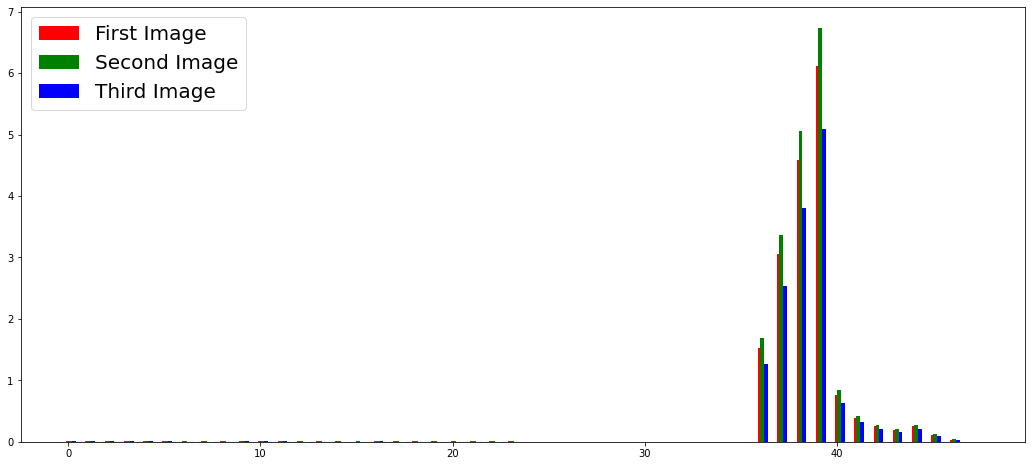

In [52]:
## Try the function
visualize_features([0,30,59] , feature_vectors)

**2.5** (Optional) Try the function using a different set of images

In [ ]:
# Your solution here

Explain which features are most important to a given image and with each derivatives are related.

## Answer
From the previous plots we can see that the most of the high responses are from filters 36 onwards, with the highest response in filters 36 to 40. Those filters correspond to the gaussian blobs and laplacians:

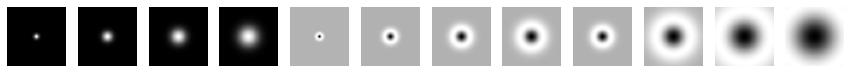

In [56]:
print_images(filter_bank[36:], colormap='gray')

This makes sense, because the images do not have very linear textures, and these filters obtain high response in dotter textures

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**2.5** Extract the image features using ``pizza.jpg`` and look for the most similar image in the whole dataset by comparing its features with those extracted from ``all_images``. What index was found in ``feature_vectors``?

Show the two images.


In [57]:
# Your solution here
#Function that computes the dinstance between two given images. Very slow
def distance(img1, img2, filter_bank, n_filters):
    return np.linalg.norm(extract_features(img1, filter_bank, n_filters) - extract_features(img2, filter_bank, n_filters))

#Function that computes the distance between the feature vector of a given image and all the images, and returns the closest one
def find_closest(img, img_collection, filter_bank, n_filters):
    img_features = extract_features(img, filter_bank, n_filters)
    distances = np.asarray([np.linalg.norm(img_features - extract_features(col_img, filter_bank, n_filters)) for col_img in img_collection])
    return np.argmin(distances)
    
#Same as avobe but with the features precomputed and passed as a parameter. The one that we will use
def find_closest_computed(img_features, col_features):
    return np.argmin([np.linalg.norm(img_features - col_img) for col_img in col_features])

[1.58030226e-02 1.43530700e-02 1.41489582e-02 1.57999074e-02
 1.70876971e-02 1.72832990e-02 1.00621562e-02 8.59869296e-03
 7.95522798e-03 8.67853597e-03 9.89674213e-03 1.07254142e-02
 7.66968999e-03 6.44975108e-03 5.49431671e-03 5.72522331e-03
 6.72369567e-03 7.87234799e-03 7.06673483e-03 6.39564184e-03
 6.39084206e-03 7.49274570e-03 7.76181953e-03 7.70747440e-03
 2.30941988e-03 1.98230565e-03 1.90826488e-03 2.31078413e-03
 2.51654207e-03 2.53182227e-03 1.18212514e-03 9.70020643e-04
 9.25453648e-04 1.05649939e-03 1.21335886e-03 1.29035639e-03
 1.53557144e+00 3.07114288e+00 4.60671426e+00 6.14210805e+00
 7.67785721e-01 3.83892860e-01 2.55928444e-01 1.91831073e-01
 2.55928444e-01 1.17915282e-01 3.74541655e-02 3.39355233e-03]


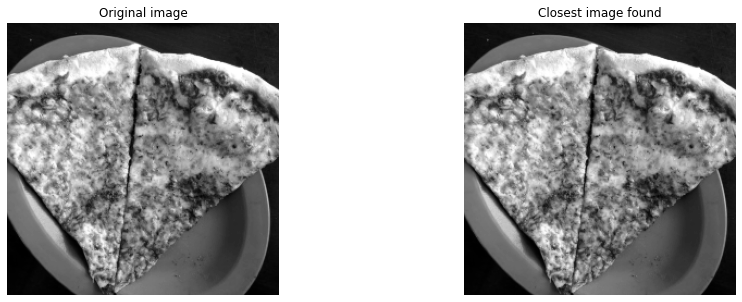

In [60]:
#Load pizza, resize it and convert it to grayscale
pizza = io.imread("./images/pizza.jpg")
pizza = rgb2gray(resize(pizza, (250,250, 3))) 

#Extract its features
n_filters = len(filter_bank)
features = extract_features(pizza, filter_bank, n_filters)
print(features)

#Find the closest one
closest_pizza_idx = find_closest_computed(features, feature_vectors)
print_images([pizza, all_images[closest_pizza_idx]], ["Original image", "Closest image found"], colormap='gray')

**2.6** (Optional) Repeat the process using ``/images/dog.jpg`` and ``/images/flower.jpg``

In [61]:
# Your solution here

flower = io.imread("./images/flower.jpg")
n_filters = len(filter_bank)
flower = rgb2gray(resize(flower, (250,250, 3))) 
features = extract_features(flower, filter_bank, n_filters)
print(features)

closest_flower_idx = find_closest_computed(features, feature_vectors)
print(closest_flower_idx)

[1.10452066e-02 1.19141265e-02 1.35740264e-02 1.41486018e-02
 1.29881425e-02 1.16499751e-02 7.41365822e-03 8.15298058e-03
 9.16755299e-03 9.58079404e-03 8.69535046e-03 7.59484025e-03
 5.64039697e-03 6.25531178e-03 7.02192540e-03 7.17228466e-03
 6.60703524e-03 5.74100041e-03 4.40963353e-03 4.79224555e-03
 5.70357012e-03 6.25543891e-03 5.53053278e-03 4.70929924e-03
 1.51326398e-03 1.68839319e-03 1.91512853e-03 2.19269929e-03
 1.86670351e-03 1.55445922e-03 8.85695704e-04 1.01397956e-03
 1.12748371e-03 1.24071348e-03 1.10910229e-03 9.01425604e-04
 1.28360629e+00 2.56721257e+00 3.85081880e+00 5.13427659e+00
 6.41803143e-01 3.20901571e-01 2.13934272e-01 1.60354357e-01
 2.13934272e-01 9.85670828e-02 3.13084764e-02 3.25361505e-03]
31


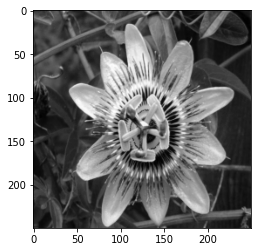

In [62]:
#Chech if it's the same image as expected:
plt.imshow(all_images[closest_flower_idx], cmap='gray')

In [63]:
dog = io.imread("./images/dog.jpg")
n_filters = len(filter_bank)
dog = rgb2gray(resize(dog, (250,250, 3))) 
features = extract_features(dog, filter_bank, n_filters)
print(features)

closest_dog_idx = find_closest_computed(features, feature_vectors)
print(closest_dog_idx)

[6.62132888e-03 6.52005891e-03 7.58003570e-03 8.77490250e-03
 8.57723387e-03 7.60585823e-03 4.64930732e-03 4.65740759e-03
 5.26748523e-03 6.10800190e-03 6.23186052e-03 5.56509891e-03
 3.58744006e-03 3.70955039e-03 4.10476424e-03 4.57567342e-03
 4.94961654e-03 4.37442504e-03 2.08287147e-03 2.19140124e-03
 2.62934721e-03 3.25286666e-03 3.15027147e-03 2.49612573e-03
 8.66219655e-04 8.86275929e-04 1.03510334e-03 1.35096108e-03
 1.31518991e-03 1.06156312e-03 4.92501984e-04 5.24130172e-04
 6.02473312e-04 7.61905208e-04 7.71540103e-04 6.44375018e-04
 1.14866819e+00 2.29733637e+00 3.44600451e+00 4.59453981e+00
 5.74334093e-01 2.87167047e-01 1.91444601e-01 1.43497231e-01
 1.91444601e-01 8.82052959e-02 2.80171975e-02 2.32598530e-03]
69


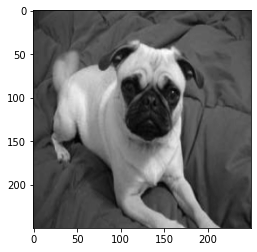

In [64]:
#Chech if it's the same image as expected:
plt.imshow(all_images[closest_dog_idx], cmap='gray')